# ISB-CGC Community Notebooks



```
Title:   How to run statistics inside BigQuery
Author:  J Ross Thomson; drj_AT_google.com
Created: 2023-05-01
Purpose: Demonstrate the use of Statslib UDFs for BigQuery
Medium:  https://medium.com/@jrossthomson/how-to-run-statistics-inside-bigquery-95c0c6864f23
Notes:   Works in Google Colaboratory notebooks.
Github:  https://github.com/GoogleCloudPlatform/bigquery-utils/tree/master/udfs/community#statslib-statistical-udfs
Repo:    https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_run_statistics_inside_BigQuery.ipynb
```

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_run_statistics_inside_BigQuery.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_run_statistics_inside_BigQuery.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
</table>

**Big data is hard**. Statistics is even harder. Doing statistics on big data is mind-blowingly hard. We are going to provide some tools to start you on a road to making statistics on big data, if not easy, at least possible.

In this notebook we will demonstrate how to run statistical tests directly in BigQuery. We make use of the BigQuery Utils package, where we have a section called StatsLib. [It can be found on Github](https://github.com/GoogleCloudPlatform/bigquery-utils/tree/master/udfs/community#statslib-statistical-udfs).

# Getting started
The key requirement of this notebook is to have a Google Cloud Project to work with.

* If you have a project, you just need to have the [project id](https://support.google.com/googleapi/answer/7014113?hl=en).
* To create a project, [this guide provides the instructions to do it](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

## Google Authentication
To authorize Google Cloud client libraries to run on Colab, it is [necessary to authenticate](https://cloud.google.com/sdk/gcloud/reference/auth/application-default/login) using the `application-default` login. The steps are simple:

1. Execute the code cell below.
1. This will output a URL.
1. Clicking on this URL will pop out a new browser tab.
1. Select the account you are using in Colab, it should be the default.
1. Select `Allow` to enable access to your Cloud resources.
1. Select `Copy` to get the authorization code.
1. Paste the authorization code into the text box next to `Enter authorization code:`

The successful output of this will start with `Credentials saved to file:`

In [ ]:
!gcloud auth application-default login

## Set Project ID
For this notebook, you need to configure `gcloud` to work with your project. Update `[MY_PROJECT_ID]` below with the project ID of your project.

In [ ]:
project_id = "[MY_PROJECT_ID]"
!gcloud config set project {project_id}
!gcloud config list


---


## Starting Python
Here you need to import the Python libraries used in the code below.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_gbq

# Use Python to query data from BigQuery

As described in the Medium.com post, you can create query to extract data from tables (in this case, from the Iris public dataset), and immediately run the t-Test UDF.

This Python function creates and executes a query running the bigquery-utils UDF: t_test. The output of this query  provides the [T value and the degrees of freedom DOF](https://towardsdatascience.com/the-statistical-analysis-t-test-explained-for-beginners-and-experts-fd0e358bbb62).

The output should be `{'t_value': 5.629165259719834, 'dof': 98}`.

In [4]:
def get_t_test(feature="sepal_length", species1="versicolor", species2="virginica"):

  query = """
  SELECT bqutil.fn.t_test(
    ARRAY(SELECT {0} from `bigquery-public-data.ml_datasets.iris` WHERE species = "{1}"),
    ARRAY(SELECT {0} from `bigquery-public-data.ml_datasets.iris` WHERE species = "{2}")
  )
  AS t_test;
  """.format(feature, species1, species2)
  return(pandas_gbq.read_gbq(query,project_id=project_id))
get_t_test()

/usr/local/lib/python3.10/dist-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading: 100%|██████████|


,t_test
0,"{'t_value': 5.629165259719834, 'dof': 98}"


## Visualizing the data
The T value, 5.629, is large enough to indicate a significant difference in the populations. To see what is going on, we can download the data, and create a plot of the dataset.

Run the next cell.

Downloading: 100%|██████████|


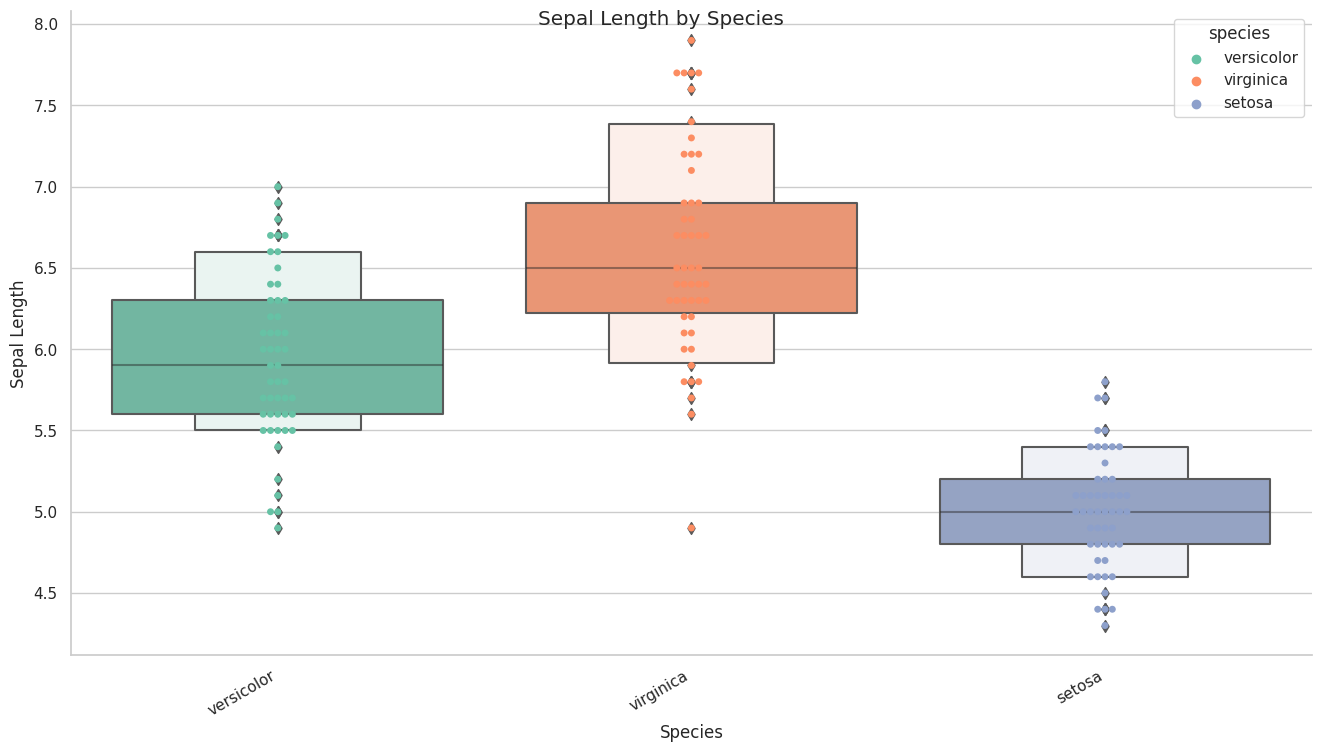

In [5]:
def get_iris_data():

  query = """
  SELECT * from `bigquery-public-data.ml_datasets.iris`
  AS iris_data;
  """
  return(pandas_gbq.read_gbq(query,project_id=project_id))

def plot_iris(df):

  sns.set_theme(style="whitegrid")
  axes = sns.catplot(x="species", y="sepal_length", data=df, kind="boxen",  height=8.27, palette="Set2", aspect=1.618)
  sns.swarmplot(x="species", y="sepal_length",data=df, hue="species", palette="Set2")

  axes.fig.suptitle(t="Sepal Length by Species")
  axes.set(ylabel="Sepal Length")
  axes.set(xlabel="Species")

  axes.fig.autofmt_xdate() # rotate values in x axis

  plt.show()
  plt.close()

df = get_iris_data()
plot_iris(df)

## Results
As you can see above there is a lot of difference in the Sepal Length between the different species.

***

# A more complicated example

Below is the query that is discussed in the Medium article. This returns a table of `gene_name` and `feature`, ranked by significance. The ordering is by the `p` value. A smaller `p` value indicates the significance of the difference in the measured populations. Understanding the populations is a bit challenging.


## Populations

There are three key fields: `study`, `gene_name` and `feature`.

* `study` refers to a collection of patients who were involved in a particular clinical study.
* `feature` refers to a specific clinical manifestation of disease
* `gene_name` refers to a known gene

The value that is being plotted in the charts below is the `protein_expression`.

All of this is explained in more detail in the [ISB-CGC documentation](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/data/TCGA_top.html).

In this case, each `gene_name` and `feature` combination represents a _population_.

Finally, the ranking of the table below, is an indication of the significance of the population variation of the `protein_expression`, as determined by the [Kruskal-Wallis Test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance).


## Observations
The key observation here is that for the first few results in the table, the `p` value is very small. This indicates a significant result.

In the next section, you will plot the first 10 items in the table.

In [6]:
def get_ranked():

  query = """SELECT protein.project_short_name AS study,
                    gene_name AS gene_name,
                    clinical.feature.key AS feature,
                    `bqutil.fn.kruskal_wallis`(ARRAY_AGG((clinical.feature.value,protein.protein_expression))) AS reso

              FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` protein
              JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` clinical
              ON clinical.case_barcode = SUBSTR(protein.sample_barcode,0,12)
              WHERE 1=1
              AND clinical.feature.value != 'null'
              AND protein.project_short_name = 'TCGA-BRCA'
              GROUP BY study, gene_name, feature
              HAVING reso.DoF > 3 and reso.DoF < 10 #and reso.p <= 0.001
              ORDER BY study, reso.p, feature
  """
  return(pandas_gbq.read_gbq(query,project_id=project_id))
ranked = get_ranked()
ranked

Downloading: 100%|██████████|


,study,gene_name,feature,reso
0,TCGA-BRCA,CDH1,histological_type,"{'H': 215.24318286743073, 'p': 0.0, 'DoF': 7}"
1,TCGA-BRCA,CTNNB1,histological_type,"{'H': 181.2909131490528, 'p': 0.0, 'DoF': 7}"
2,TCGA-BRCA,ESR1,histological_type,"{'H': 80.85301505100233, 'p': 9.2148511043888e..."
3,TCGA-BRCA,RPS6,histological_type,"{'H': 72.17695808882127, 'p': 5.35904653986563..."
4,TCGA-BRCA,SLC1A5,histological_type,"{'H': 67.5597360393931, 'p': 1.292965734478457..."
...,...,...,...,...
763,TCGA-BRCA,RPTOR,histological_type,"{'H': 1.076537723979527, 'p': 0.99349761730779..."
764,TCGA-BRCA,BAP1,anatomic_neoplasm_subdivision,"{'H': 1.4721384490721903, 'p': 0.9973482314160..."
765,TCGA-BRCA,RPS6KB1,icd_o_3_site,"{'H': 0.1332152137410958, 'p': 0.9996714398858..."
766,TCGA-BRCA,CASP7,icd_o_3_site,"{'H': 0.12657640785073454, 'p': 0.999710173803..."


## Visualizing the TCGA-BRCA populations by feature
The cell below defines two functions:
1. get_data(), which retrieves the full data set for a single gene in the BRCA study
1. plot_data(), which plots the protein expression data, as separated by the clinical `feature`.


In [7]:
def get_data(feature='histological_type', gene_name='CTNNB1'):
  query = """SELECT protein.project_short_name AS study, clinical.feature.value,
                    protein.protein_expression

              FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` protein
              JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` clinical
              ON clinical.case_barcode = SUBSTR(protein.sample_barcode,0,12)
              WHERE 1=1
              AND protein.project_short_name = 'TCGA-BRCA'
              AND clinical.feature.key = '{}'
              AND gene_name = '{}'
  """.format(feature, gene_name)


  df = pandas_gbq.read_gbq(query,project_id=project_id)
  return(df)

def plot_data(df, feature='histological_type', gene_name='CTNNB1', p_value=0.0):

  sns.set_theme(style="whitegrid")
  axes = sns.catplot(x="value", y="protein_expression", data=df, kind="boxen",  height=8.27, order=df.value.value_counts().index, palette="Set2", aspect=1.618)
  sns.violinplot(x="value", y="protein_expression",data=df, scale="count", order=df.value.value_counts().index, palette="Set2", aspect=1.618)

  axes.fig.suptitle(t="Protein expression for gene: '{}' vs clinical feature: '{}', p={}".format(gene_name, feature, p_value))
  axes.set(ylabel="Protein Expression")
  axes.set(xlabel="Clinical Feature")

  axes.fig.autofmt_xdate() # rotate values in x axis

  plt.show()
  plt.close()


## Creating plots of the top 10 most significant results
  Using the `ranked` data, obtained above, you will be running a for loop for the top 10 results and creating a plot for each.

Downloading: 100%|██████████|


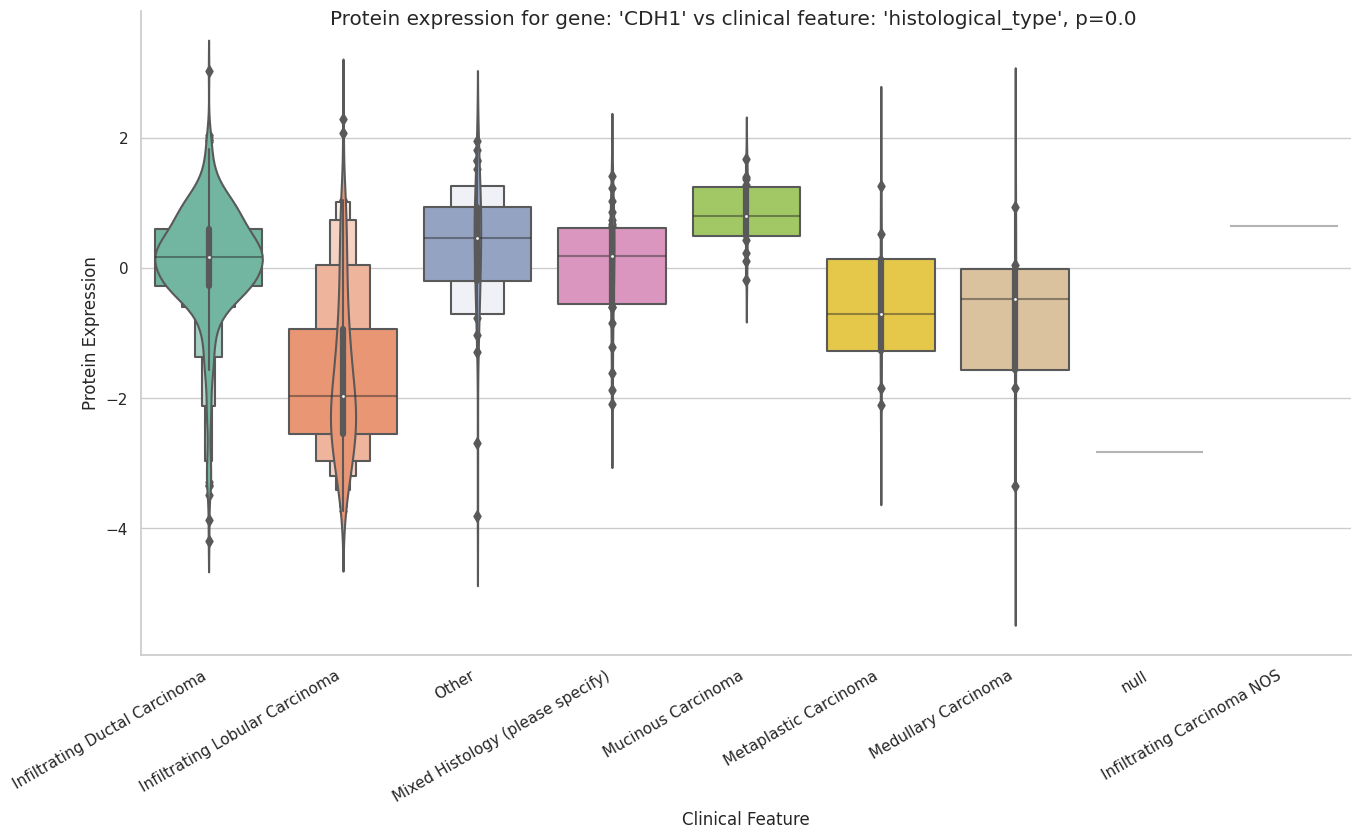

Downloading: 100%|██████████|


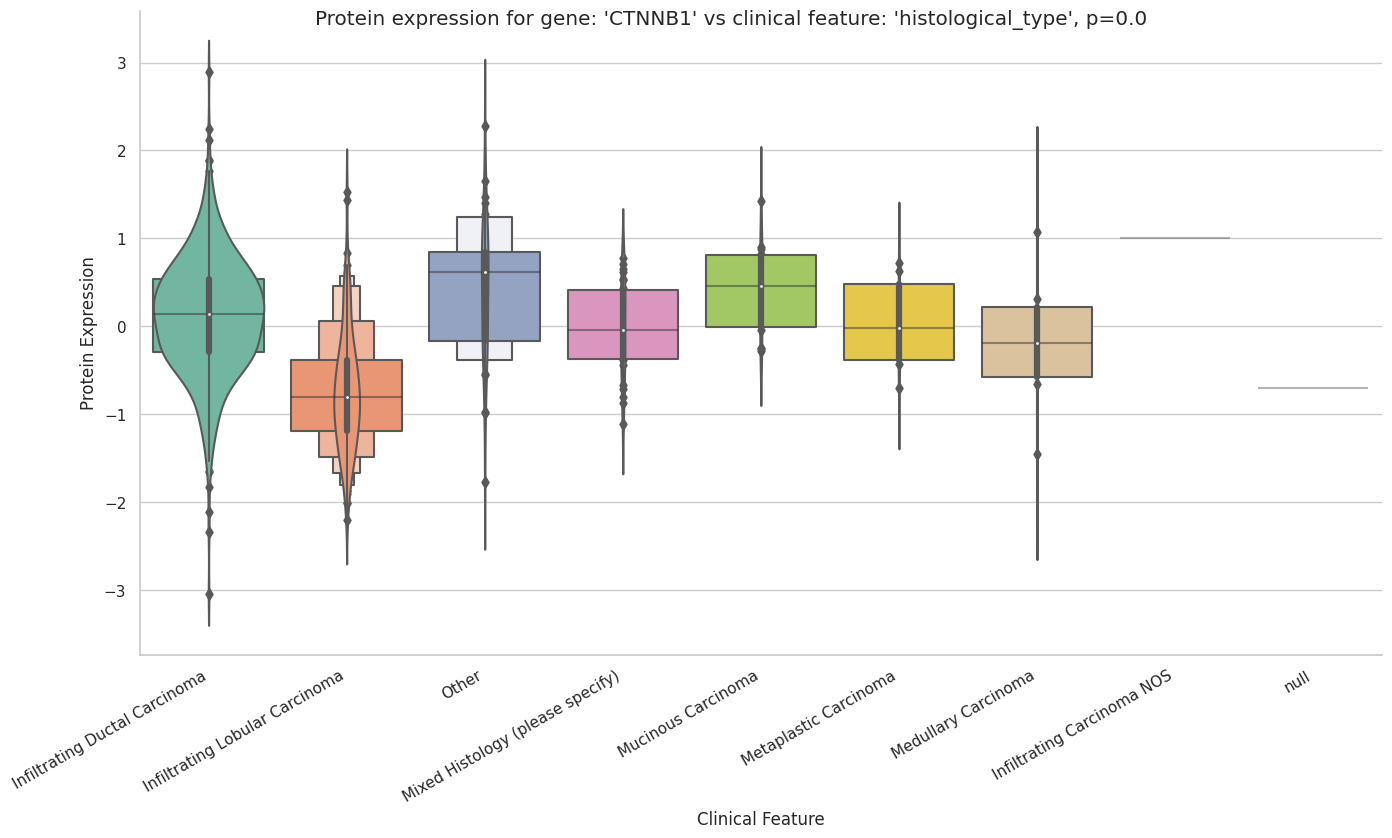

Downloading: 100%|██████████|


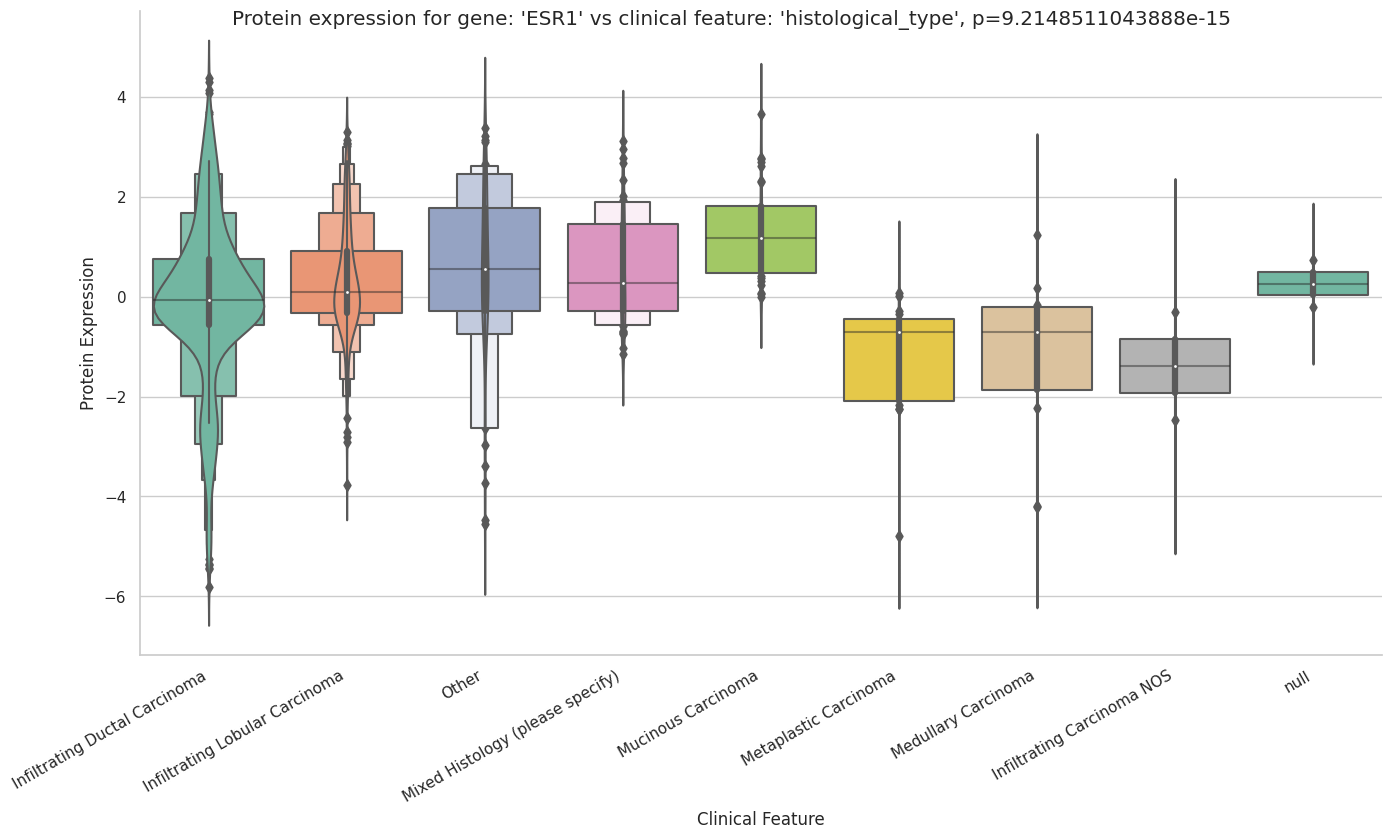

Downloading: 100%|██████████|


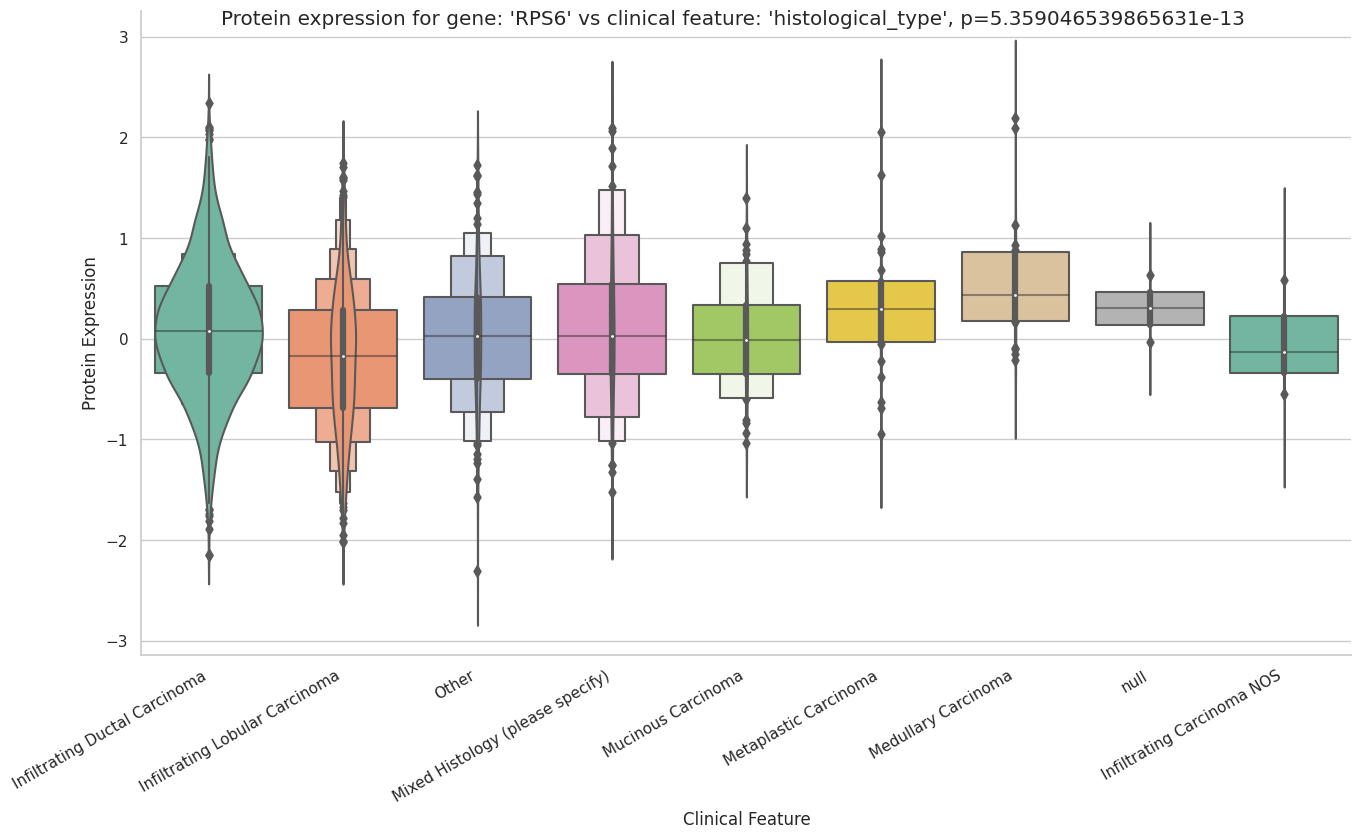

Downloading: 100%|██████████|


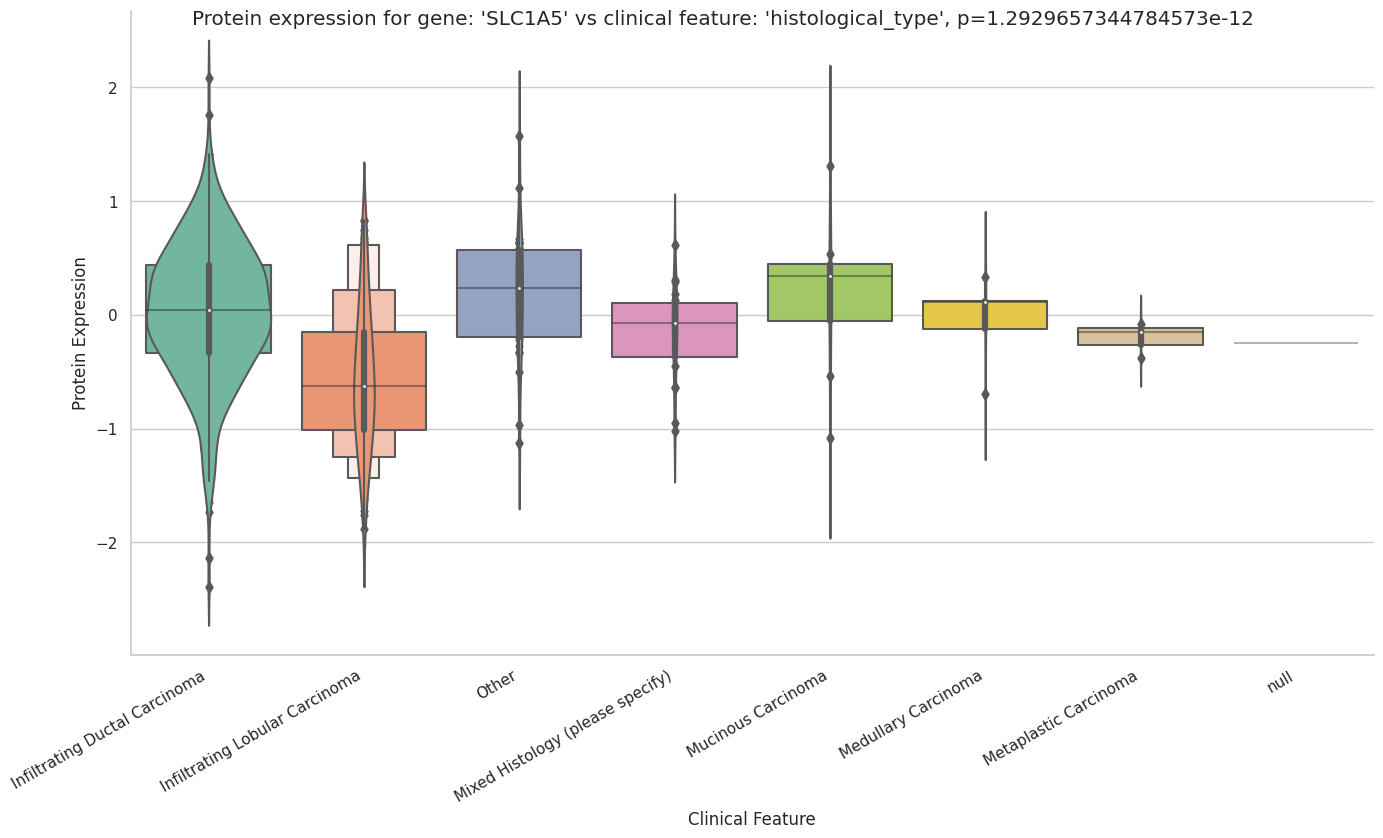

Downloading: 100%|██████████|


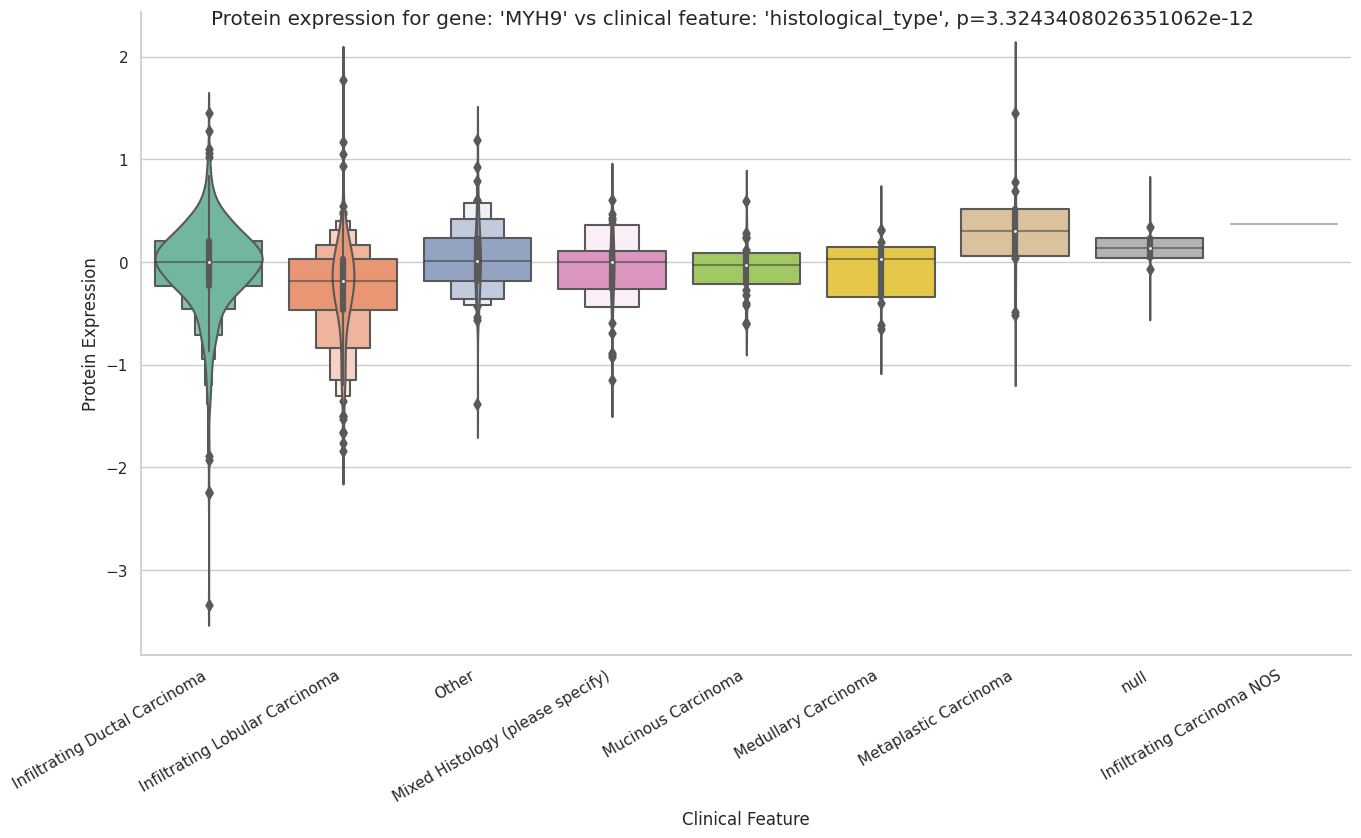

Downloading: 100%|██████████|


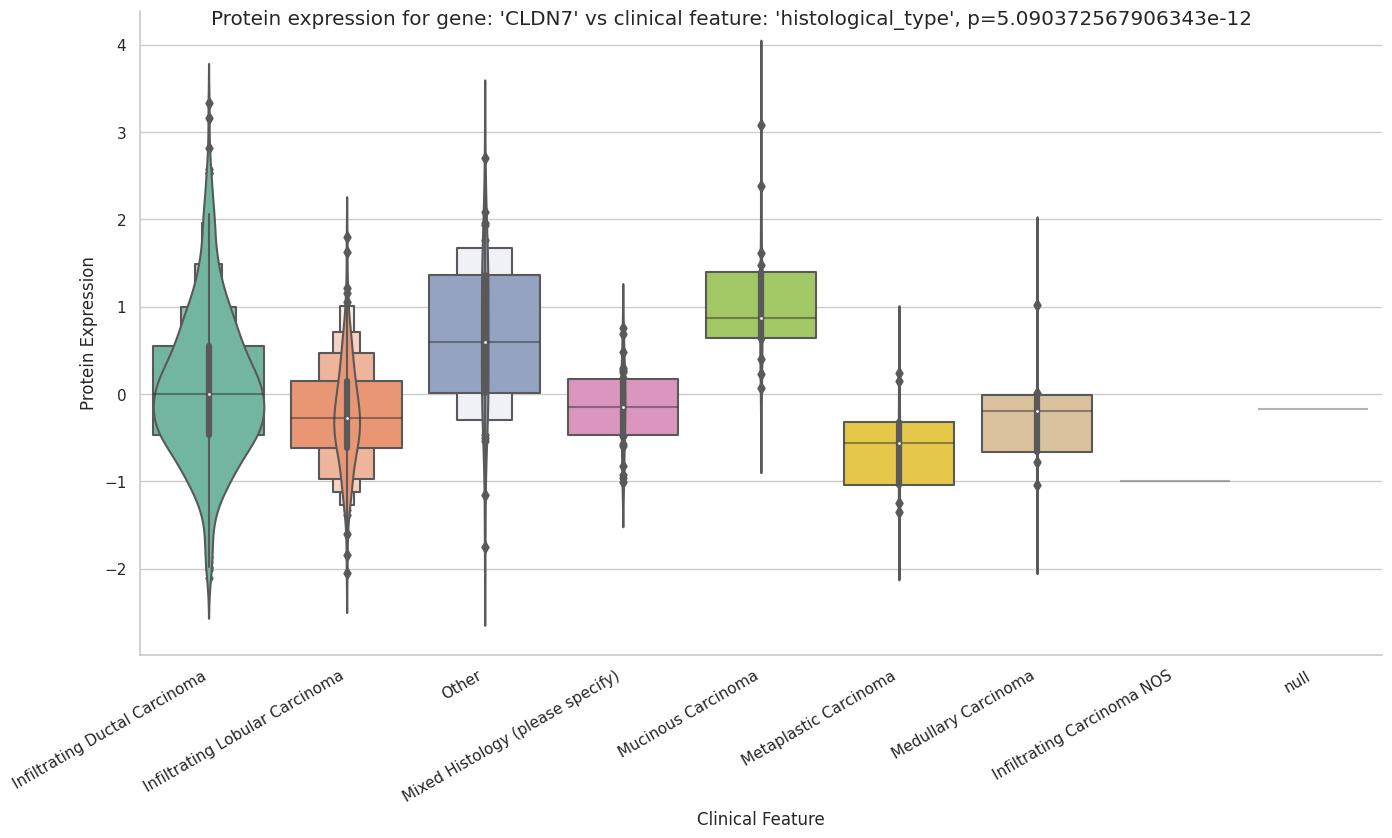

Downloading: 100%|██████████|


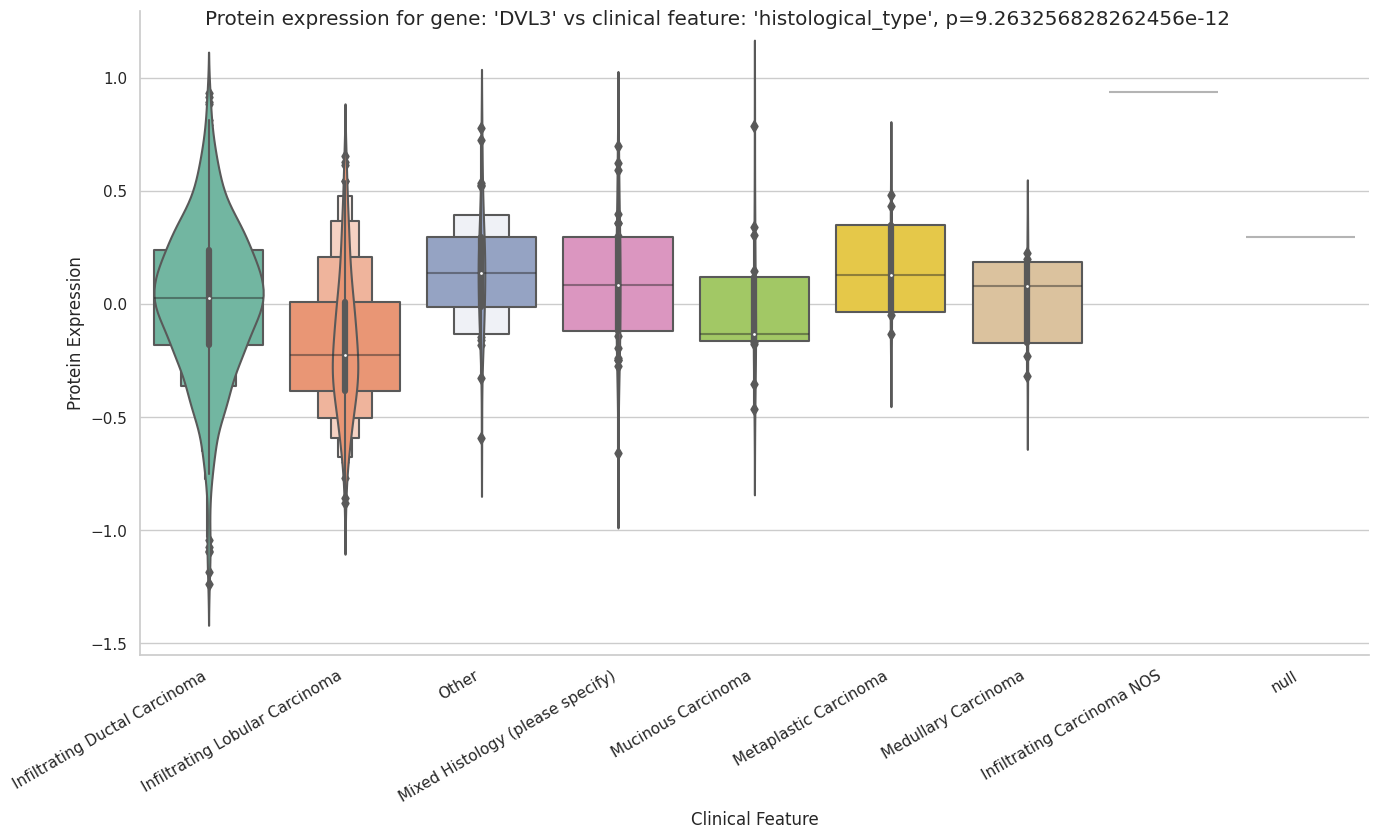

Downloading: 100%|██████████|


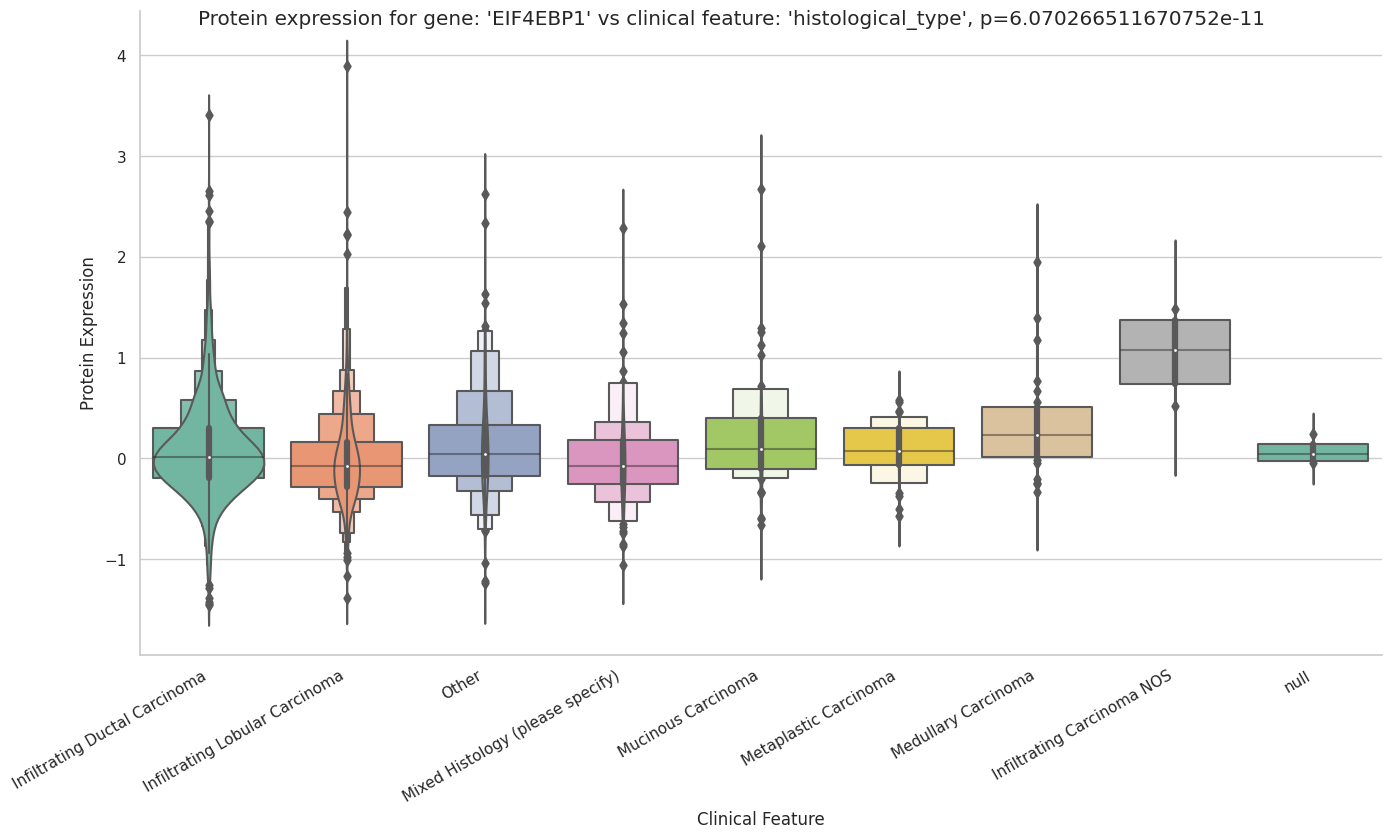

Downloading: 100%|██████████|


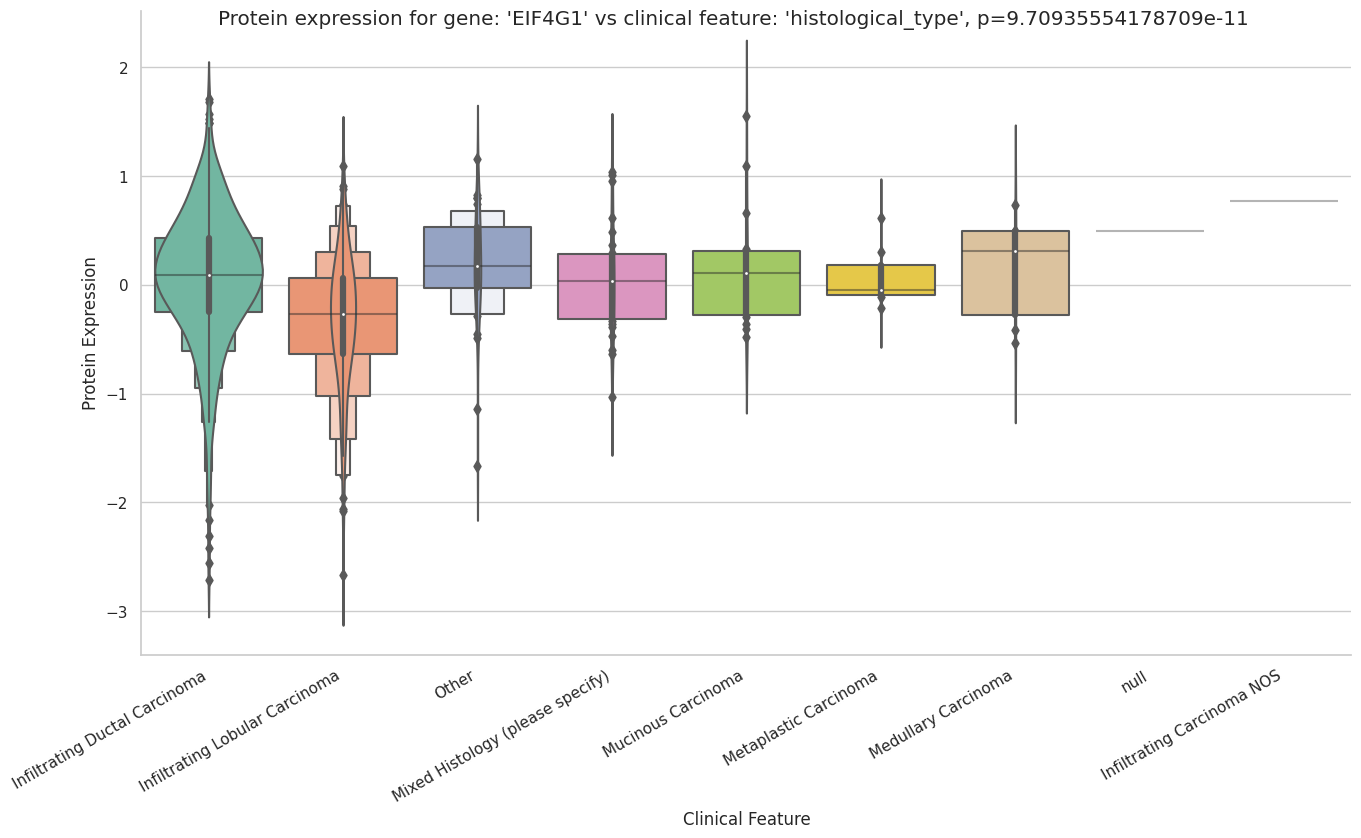

Downloading: 100%|██████████|


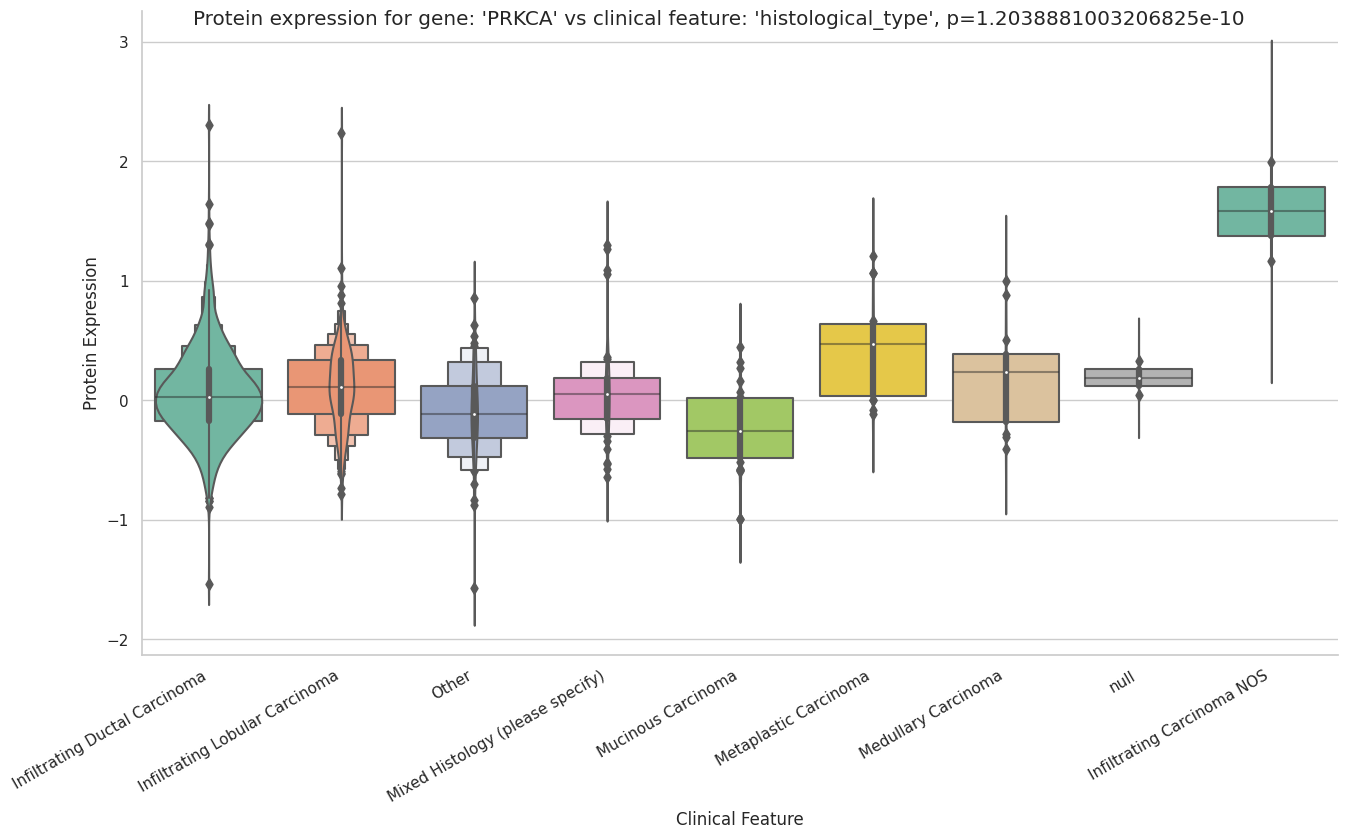

Downloading: 100%|██████████|


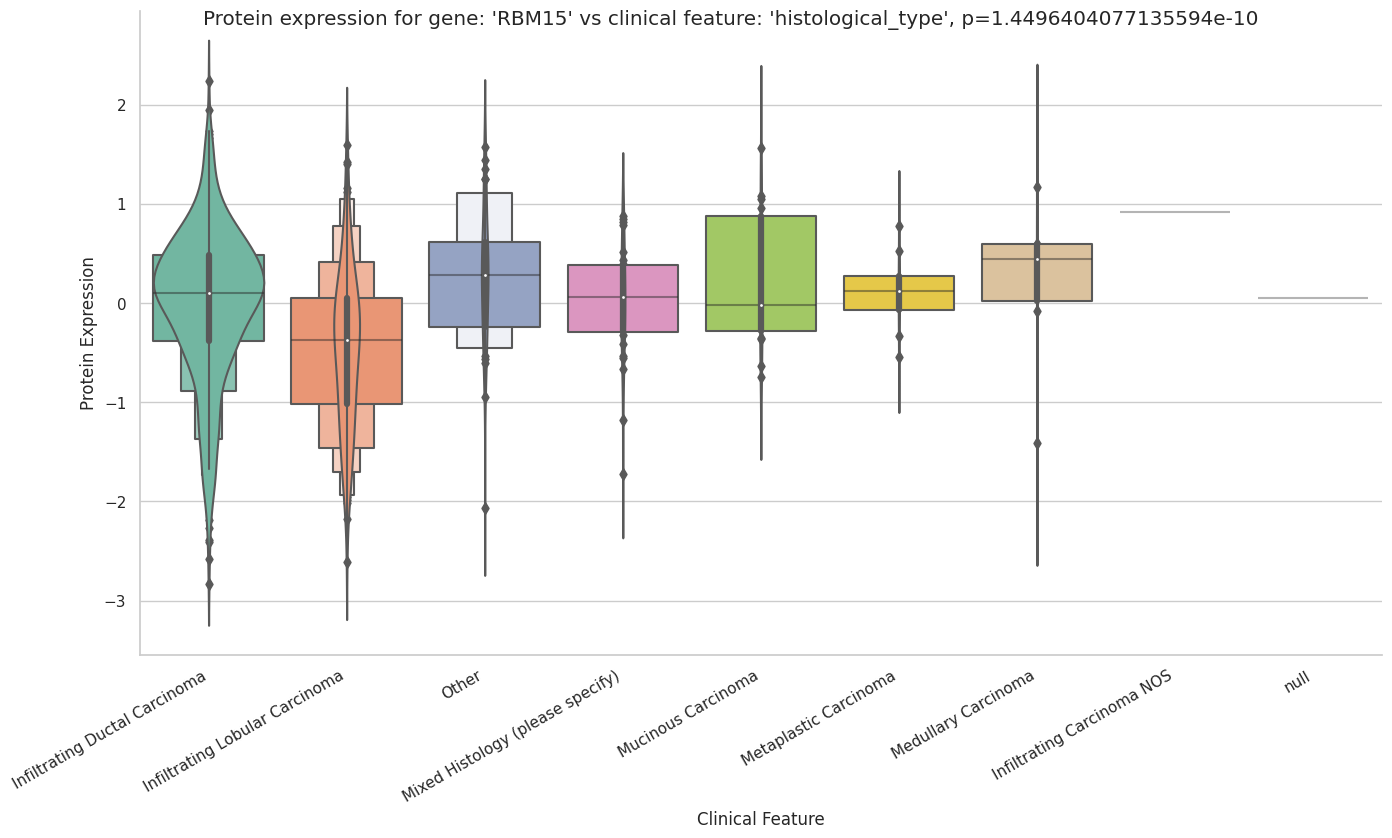

In [8]:
for i in ranked.index:
  df = get_data(feature=ranked['feature'][i], gene_name=ranked['gene_name'][i])
  plot_data(df, feature=ranked['feature'][i], gene_name=ranked['gene_name'][i], p_value=ranked['reso'][i].get('p'))
  if i > 10:
    break


# Conclusions
Observing the plots, you should be able to detect that the populations for each gene plotted again Clinical Feature, do show a significant difference in the Protein Expression.

This method allows you to analyze the significance across 767 genes, for almost 1000 patients, very quickly, without downloading the entire dataset. This was obtained almost instantaneously. This can be a massive savings in time and effort to analyse data.

BigQuery is capable of running queries of Petabyte sized dataset, and with the growth of genomics dataset, among others, traditional methods of statistical studies are going to be hugely challenging without methods where the data remains in the data warehouse.

# What's next

We are looking for collaborators on the Statslib package, to get more statistical analyses into the BigQuery Utils platform. Please reach out to drj_AT_google.com to get started.